Data Processing

In [7]:
!pip install tensorflow matplotlib numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Example: Splitting the dataset into train, test, and validation
dataset_path = 'dataset_resized'
output_path = 'output_dataset'

# Create directories for train, test, and validation sets
for split_type in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(output_path, split_type), exist_ok=True)

classes = os.listdir(dataset_path)
print(classes)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]

    # Split into train, test, and validation
    train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

    # Copy images to respective directories
    for img_list, split_dir in zip([train_images, test_images, val_images], ['train', 'test', 'validation']):
        os.makedirs(os.path.join(output_path, split_dir, class_name), exist_ok=True)
        for img_path in img_list:
            shutil.copy(img_path, os.path.join(output_path, split_dir, class_name, os.path.basename(img_path)))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Prepare dataset

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define dataset and image settings
dataset_path = 'dataset_resized'
img_width, img_height = 150, 150
batch_size = 32

# Create ImageDataGenerators for data loading and augmentation
# The validation_split is used to create a validation set from the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

# Load and prepare the training and validation data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print(train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


Build the CNN model

In [10]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [11]:
epochs = 10
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = train_generator.samples // train_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Specify the filename for your HDF5 file
h5_filepath = 'trashnet_model.h5'

# Save the model to the HDF5 format
model.save(h5_filepath)

print(f"Model saved to {h5_filepath}")

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.2269 - loss: 1.7877 - val_accuracy: 0.3221 - val_loss: 1.6388
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2812 - loss: 1.7162 - val_accuracy: 0.2843 - val_loss: 1.6521
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.4076 - loss: 1.4361 - val_accuracy: 0.3817 - val_loss: 1.4814
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5000 - loss: 1.3002 - val_accuracy: 0.3698 - val_loss: 1.4894
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5256 - loss: 1.2317 - val_accuracy: 0.3917 - val_loss: 1.4186
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3438 - loss: 1.4953 - val_accuracy: 0.4294 - val_loss: 1.4227
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.5622 - loss: 1.1106 - val_accuracy: 0.3857 - val_loss: 1.5002
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6562 - loss: 0.9393 - val_accuracy: 0.3936

Model saved to trashnet_model.h5


Evaluate and visualize

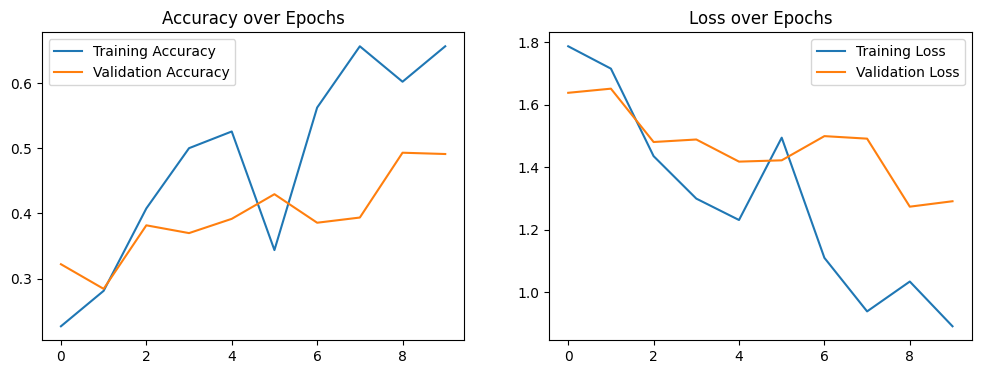

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()